In [1]:
import os
os.chdir("../data/immune_dictionary")

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [3]:
cell_types = ["B_cells", "cDC1", "cDC2", "eTAC", "ILC", "Macrophage", "MigDC", "Monocyte", "Neutrophil", "NK_cell", "pDC", 
              "T_cell_CD4", "T_cell_CD8", "T_cell_gd", "Treg"]

x_dirs = [f"{i}_normalized.csv" for i in cell_types]
y_dirs = [f"{i}_classes.csv" for i in cell_types]

for cell_type_n in range(len(cell_types)):
    x = pd.read_csv(x_dirs[cell_type_n])
    y = pd.read_csv(y_dirs[cell_type_n])
    x = x.sort_values("Unnamed: 0")
    x.index = x["Unnamed: 0"]
    del x["Unnamed: 0"]
    
    y = y["class"]
    y = np.ravel(y)
    if cell_type_n == 0:
        common_genes = list(x.index)
        
        x_all = x
        y_all = y
    else:
        common_genes = list(set(common_genes).intersection(set(list(x.index))))
        x_all = pd.concat([x_all[x_all.index.isin(common_genes)], x[x.index.isin(common_genes)]], axis = 1)
        y_all = np.concatenate([y_all, y])

In [4]:
x_all = x_all.transpose()
x_all = np.array(x_all)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_all,y_all, test_size = 0.3, random_state=50)

In [23]:
#SVM
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(x_train, y_train)
y_predict = svc_model.predict(x_test)

In [15]:
#accuracy
sum(y_predict == y_test)/len(y_test)

0.10882110469909316

In [7]:
#logistic regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
y_predict_logistic = classifier.predict(x_test)

In [10]:
#accuracy
sum(y_predict_logistic == y_test)/len(y_test)

0.10801430009371421

In [11]:
#Random forest
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)
y_predict_rf = random_forest.predict(x_test)

In [14]:
sum(y_predict_rf == y_test)/len(y_test)

0.10398806011592794

In [ ]:
#KNN
knn_classifier = KNeighborsClassifier(n_neighbors = 86)
knn_classifier.fit(x_train, y_train)
y_predict_knn = knn_classifier.predict(x_test)

In [26]:
sum(y_predict_knn == y_test)/len(y_test)

0.050700741962077495

In [ ]:
####scgene.......................................................................................

In [1]:
pip install scanpy

Note: you may need to restart the kernel to use updated packages.


In [120]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import scgen
import logging
import scanpy as sc
import anndata as ad

In [2]:
train = sc.read("./tests/data/train_kang.h5ad",
                backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')

/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
train

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

In [3]:
#identify mitochondrial genes
train.var["mt"] = train.var_names.str.startswith("MT-")
#identify ribosomal genes
train.var["ribo"] = train.var_names.str.startswith(("RPS", "RPL"))
#identify hemoglobin genes
train.var["hb"] = train.var_names.str.contains("^HB[^(P)]")

In [4]:
sc.pp.calculate_qc_metrics(train, inplace=True, qc_vars=["mt", "ribo", "hb"])

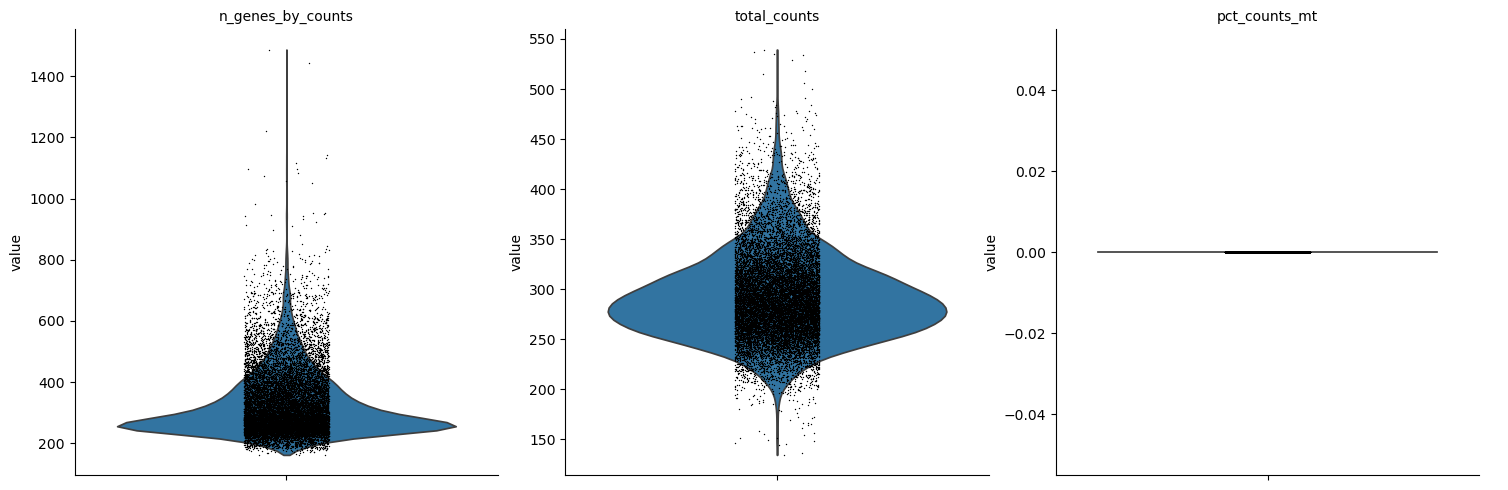

In [5]:
sc.pl.violin(
    train,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    multi_panel=True 
      )

In [6]:
sc.pp.filter_cells(train, min_counts=100)
sc.pp.filter_genes(train, min_cells=10)

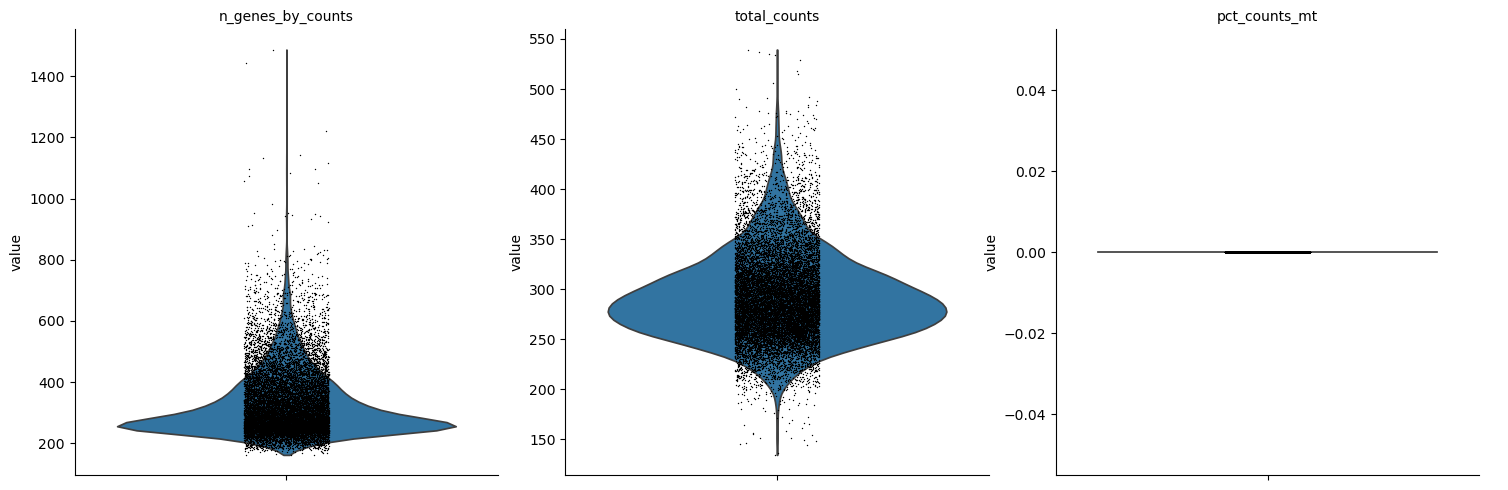

In [7]:
sc.pl.violin(
    train,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    multi_panel=True 
      )

In [8]:
#loading and merging some cell types
os.chdir("../data/immune_dictionary")
cell_types = ["B_cell", "cDC1", "cDC2", "eTAC", "ILC", "Macrophage", "MigDC", "Monocyte"]
dirs = [f"{i}_ref_data.h5ad" for i in cell_types]
for i, dir in enumerate(dirs):
    adata = sc.read(dir)
    if i == 0:
        merged = adata
        continue
    merged = sc.concat([merged, adata], join="outer")
merged.var["gene_symbol"] = adata.var.index
merged.obs["condition"] = merged.obs["sample"]

In [20]:
#adding the other cell types makes kernel crash. we won't add them for now.
cell_types = ["Neutrophil", "NK_cell", "pDC", "T_cell_CD4", "T_cell_CD8", "T_cell_gd", "Treg"]
dirs = [f"{i}_ref_data.h5ad" for i in cell_types]
for i, dir in enumerate(dirs):
    adata = sc.read(dir)
    merged = sc.concat([merged, adata], join="outer")
merged.var["gene_symbol"] = adata.var.index
merged.obs["condition"] = merged.obs["sample"]

: 

In [12]:
#already contains most variable genes
merged

AnnData object with n_obs × n_vars = 44014 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep', 'condition'
    var: 'gene_symbol'
    obsm: 'X_pca', 'X_tsne'

In [15]:
#identify mitochondrial genes
merged.var["mt"] = merged.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(merged, qc_vars=["mt"], inplace=True)

/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


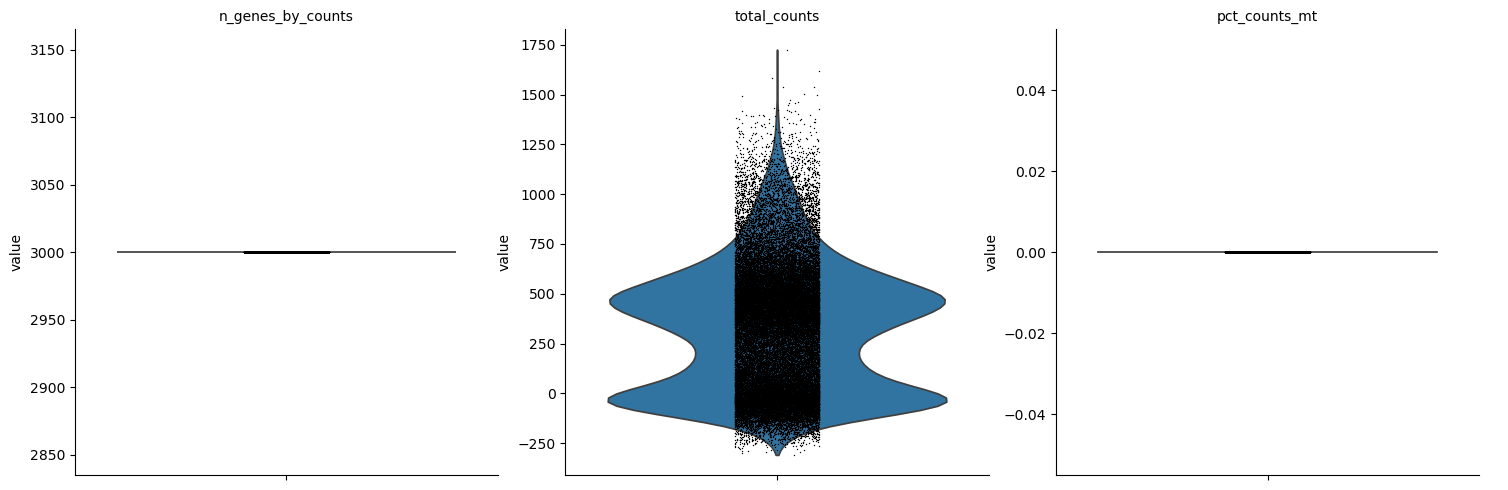

In [16]:
sc.pl.violin(
    merged,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    multi_panel=True 
      )

In [19]:
sc.pp.filter_cells(merged, min_counts=100)
sc.pp.filter_genes(merged, min_cells=10)

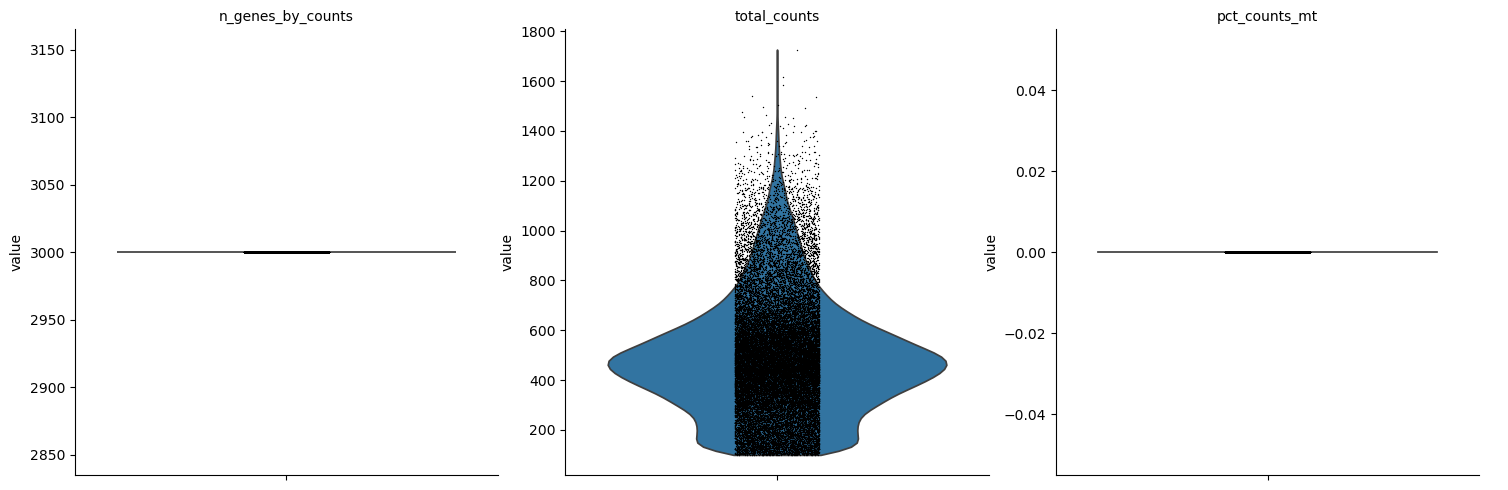

In [20]:
sc.pl.violin(
    merged,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    multi_panel=True 
      )

In [21]:
merged[merged.obs["condition"]=="PBS"]

View of AnnData object with n_obs × n_vars = 468 × 2253
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'X_pca', 'X_tsne'

In [26]:
merged[merged.obs["condition"] == "EGF"]

View of AnnData object with n_obs × n_vars = 350 × 2253
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'X_pca', 'X_tsne'

In [27]:
merged_new = merged[~((merged.obs["celltype"] =="B_cell") &
                      (merged.obs["condition"] == "EGF"))]

In [28]:
merged_new = merged_new.copy()

In [29]:
scgen.SCGEN.setup_anndata(merged_new, batch_key="condition", labels_key="celltype")

In [30]:
model = scgen.SCGEN(merged_new)
model.save("../saved_models/scGene_model_perturbation_prediction_half_merged.pt", overwrite=True)

In [31]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 26/100:  26%|██▌       | 26/100 [06:29<18:29, 15.00s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.03e+3]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 2918.770. Signaling Trainer to stop.


In [32]:
latent_X = model.get_latent_representation()

In [33]:
latent_adata = sc.AnnData(X=latent_X, obs=merged_new.obs.copy())

In [34]:
sc.tl.pca(latent_adata)

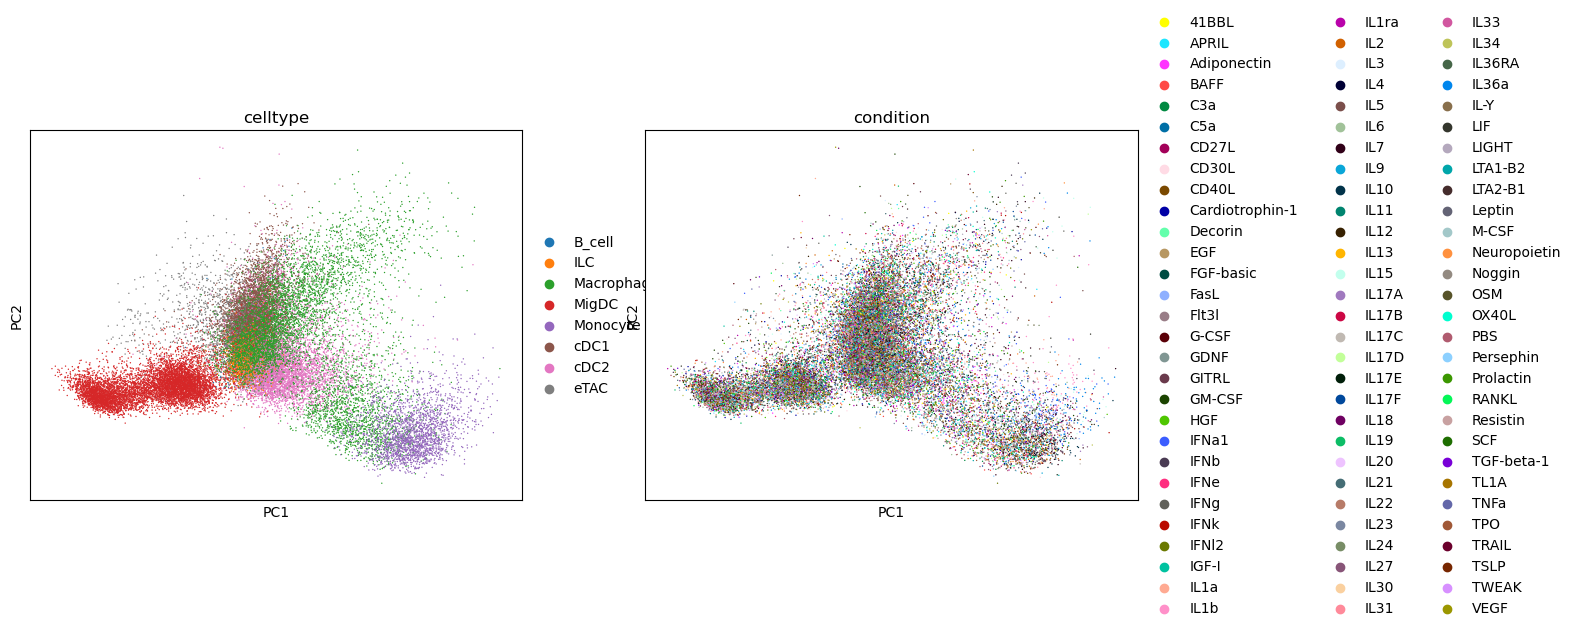

In [36]:
sc.pl.pca(
    latent_adata,
    color=["celltype", "condition"]
)

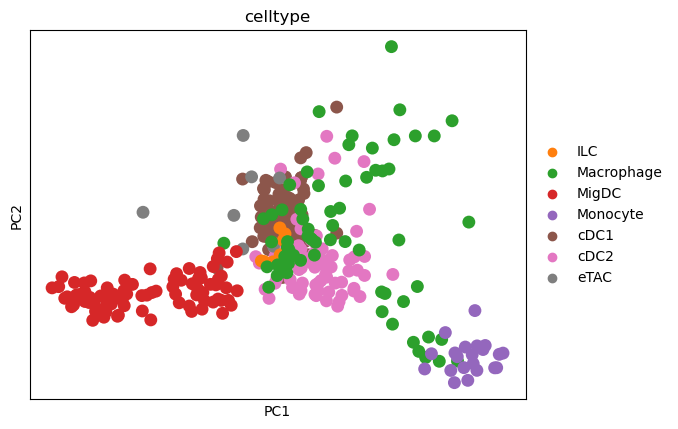

In [47]:
sc.pl.pca(
    latent_adata[(latent_adata.obs["condition"]=="EGF")],
    color="celltype"
)

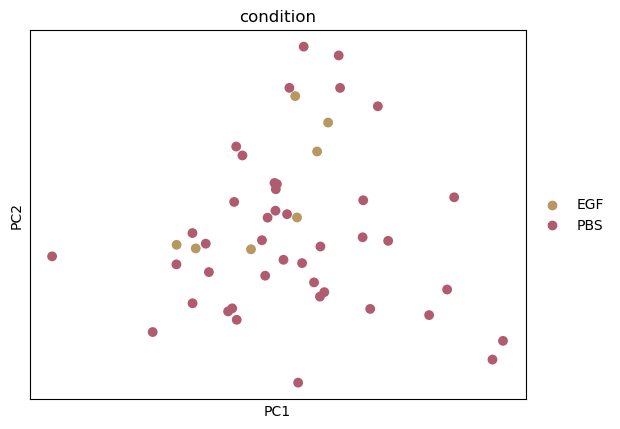

In [60]:
sc.pl.pca(
    latent_adata[((latent_adata.obs["condition"]=="PBS") | (latent_adata.obs["condition"]=="EGF")) & (latent_adata.obs["celltype"]=="ILC")],
    color="condition",
    size=200
)

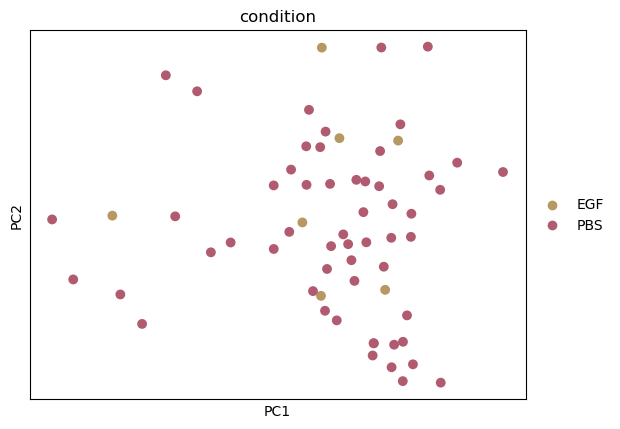

In [61]:
sc.pl.pca(
    latent_adata[((latent_adata.obs["condition"]=="PBS") | (latent_adata.obs["condition"]=="EGF")) & (latent_adata.obs["celltype"]=="eTAC")],
    color="condition",
    size=200
)

In [62]:
sc.pp.neighbors(latent_adata)

In [63]:
sc.tl.umap(latent_adata)

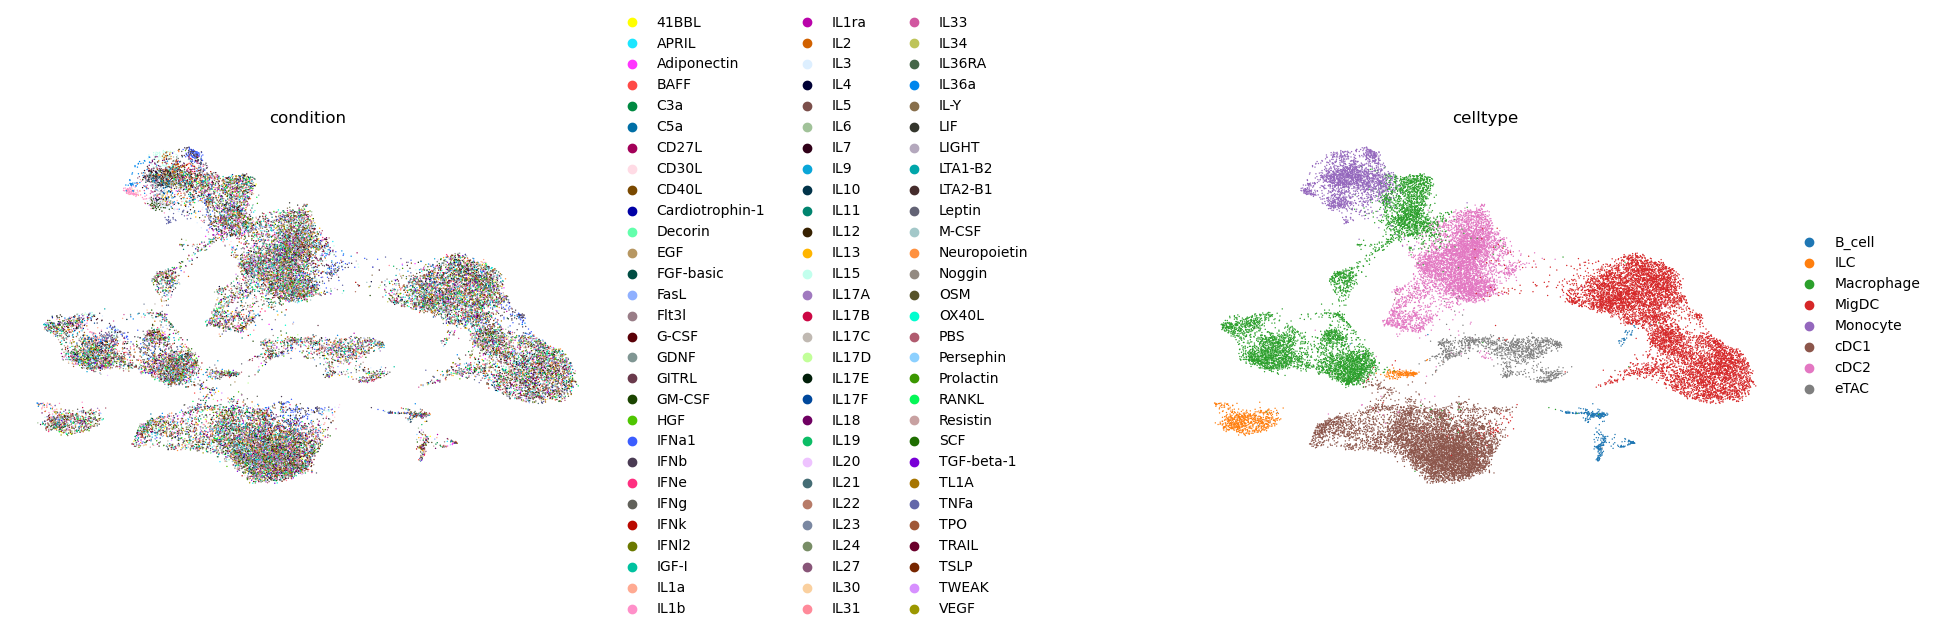

In [65]:
sc.pl.umap(latent_adata, color=['condition', 'celltype'], wspace=0.8, frameon=False,
           save='latentspace_half_merged.pdf')

In [66]:
pred, delta = model.predict(
    ctrl_key='PBS',
    stim_key='EGF',
    celltype_to_predict='B_cell'
)


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [104]:
#create perturbation vectors from the latent space
pert_list = list(set(latent_adata.obs["condition"]))
pert_list.remove("PBS")
ctrl_latent = latent_adata[latent_adata.obs["condition"] == "PBS"].X
ctrl_mean = np.mean(ctrl_latent, axis = 0)

pert_vec_dic = {}
for pert in pert_list:
    pert_latent = latent_adata[latent_adata.obs["condition"] == pert].X
    pert_mean = np.mean(pert_latent, axis = 0)
    pert_vec = pert_mean - ctrl_mean

    pert_vec_dic[pert] = np.reshape(pert_vec, (-1,1))


In [72]:
ctrl_mean = np.mean(latent_adata[latent_adata.obs["condition"]=="PBS"].X, axis=0)

In [74]:
pred_latent = model.get_latent_representation(pred)
pred_vec = np.mean(pred_latent, axis = 0) - ctrl_mean

test_latent = model.get_latent_representation(merged[(merged.obs["condition"] == "EGF") & (merged.obs["celltype"] == "B_cell")])
test_vec = np.mean(test_latent, axis = 0) - ctrl_mean
similarities = {}
for pert in pert_list:
    sim = np.dot(pert_vec_dic[pert], test_vec)
    similarities[pert] = sim

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:221: UserWarning: Category 11 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:221: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


In [151]:
pert_vectors = np.concatenate(list(pert_vec_dic.values()), axis=1)

In [140]:
all_vectors = np.concatenate([pert_vectors, np.reshape(test_vec, (-1,1))], axis=1)

In [139]:
np.reshape(test_vec, (-1,1)).shape

(100, 1)

In [141]:
from sklearn.decomposition import PCA
pca = PCA(2)
pert_vec_components = pca.fit_transform(np.transpose(all_vectors))

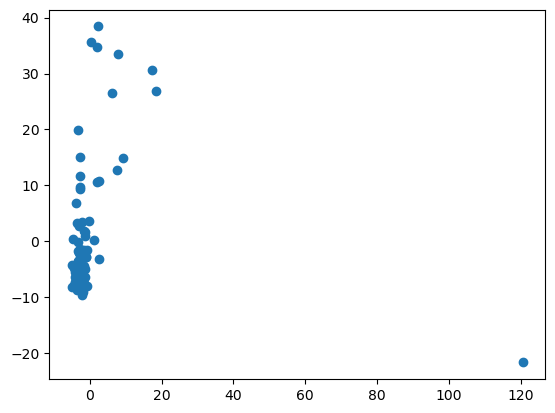

In [142]:
plt.scatter(pert_vec_components[:,0], pert_vec_components[:,1])

<Axes: xlabel='0', ylabel='1'>

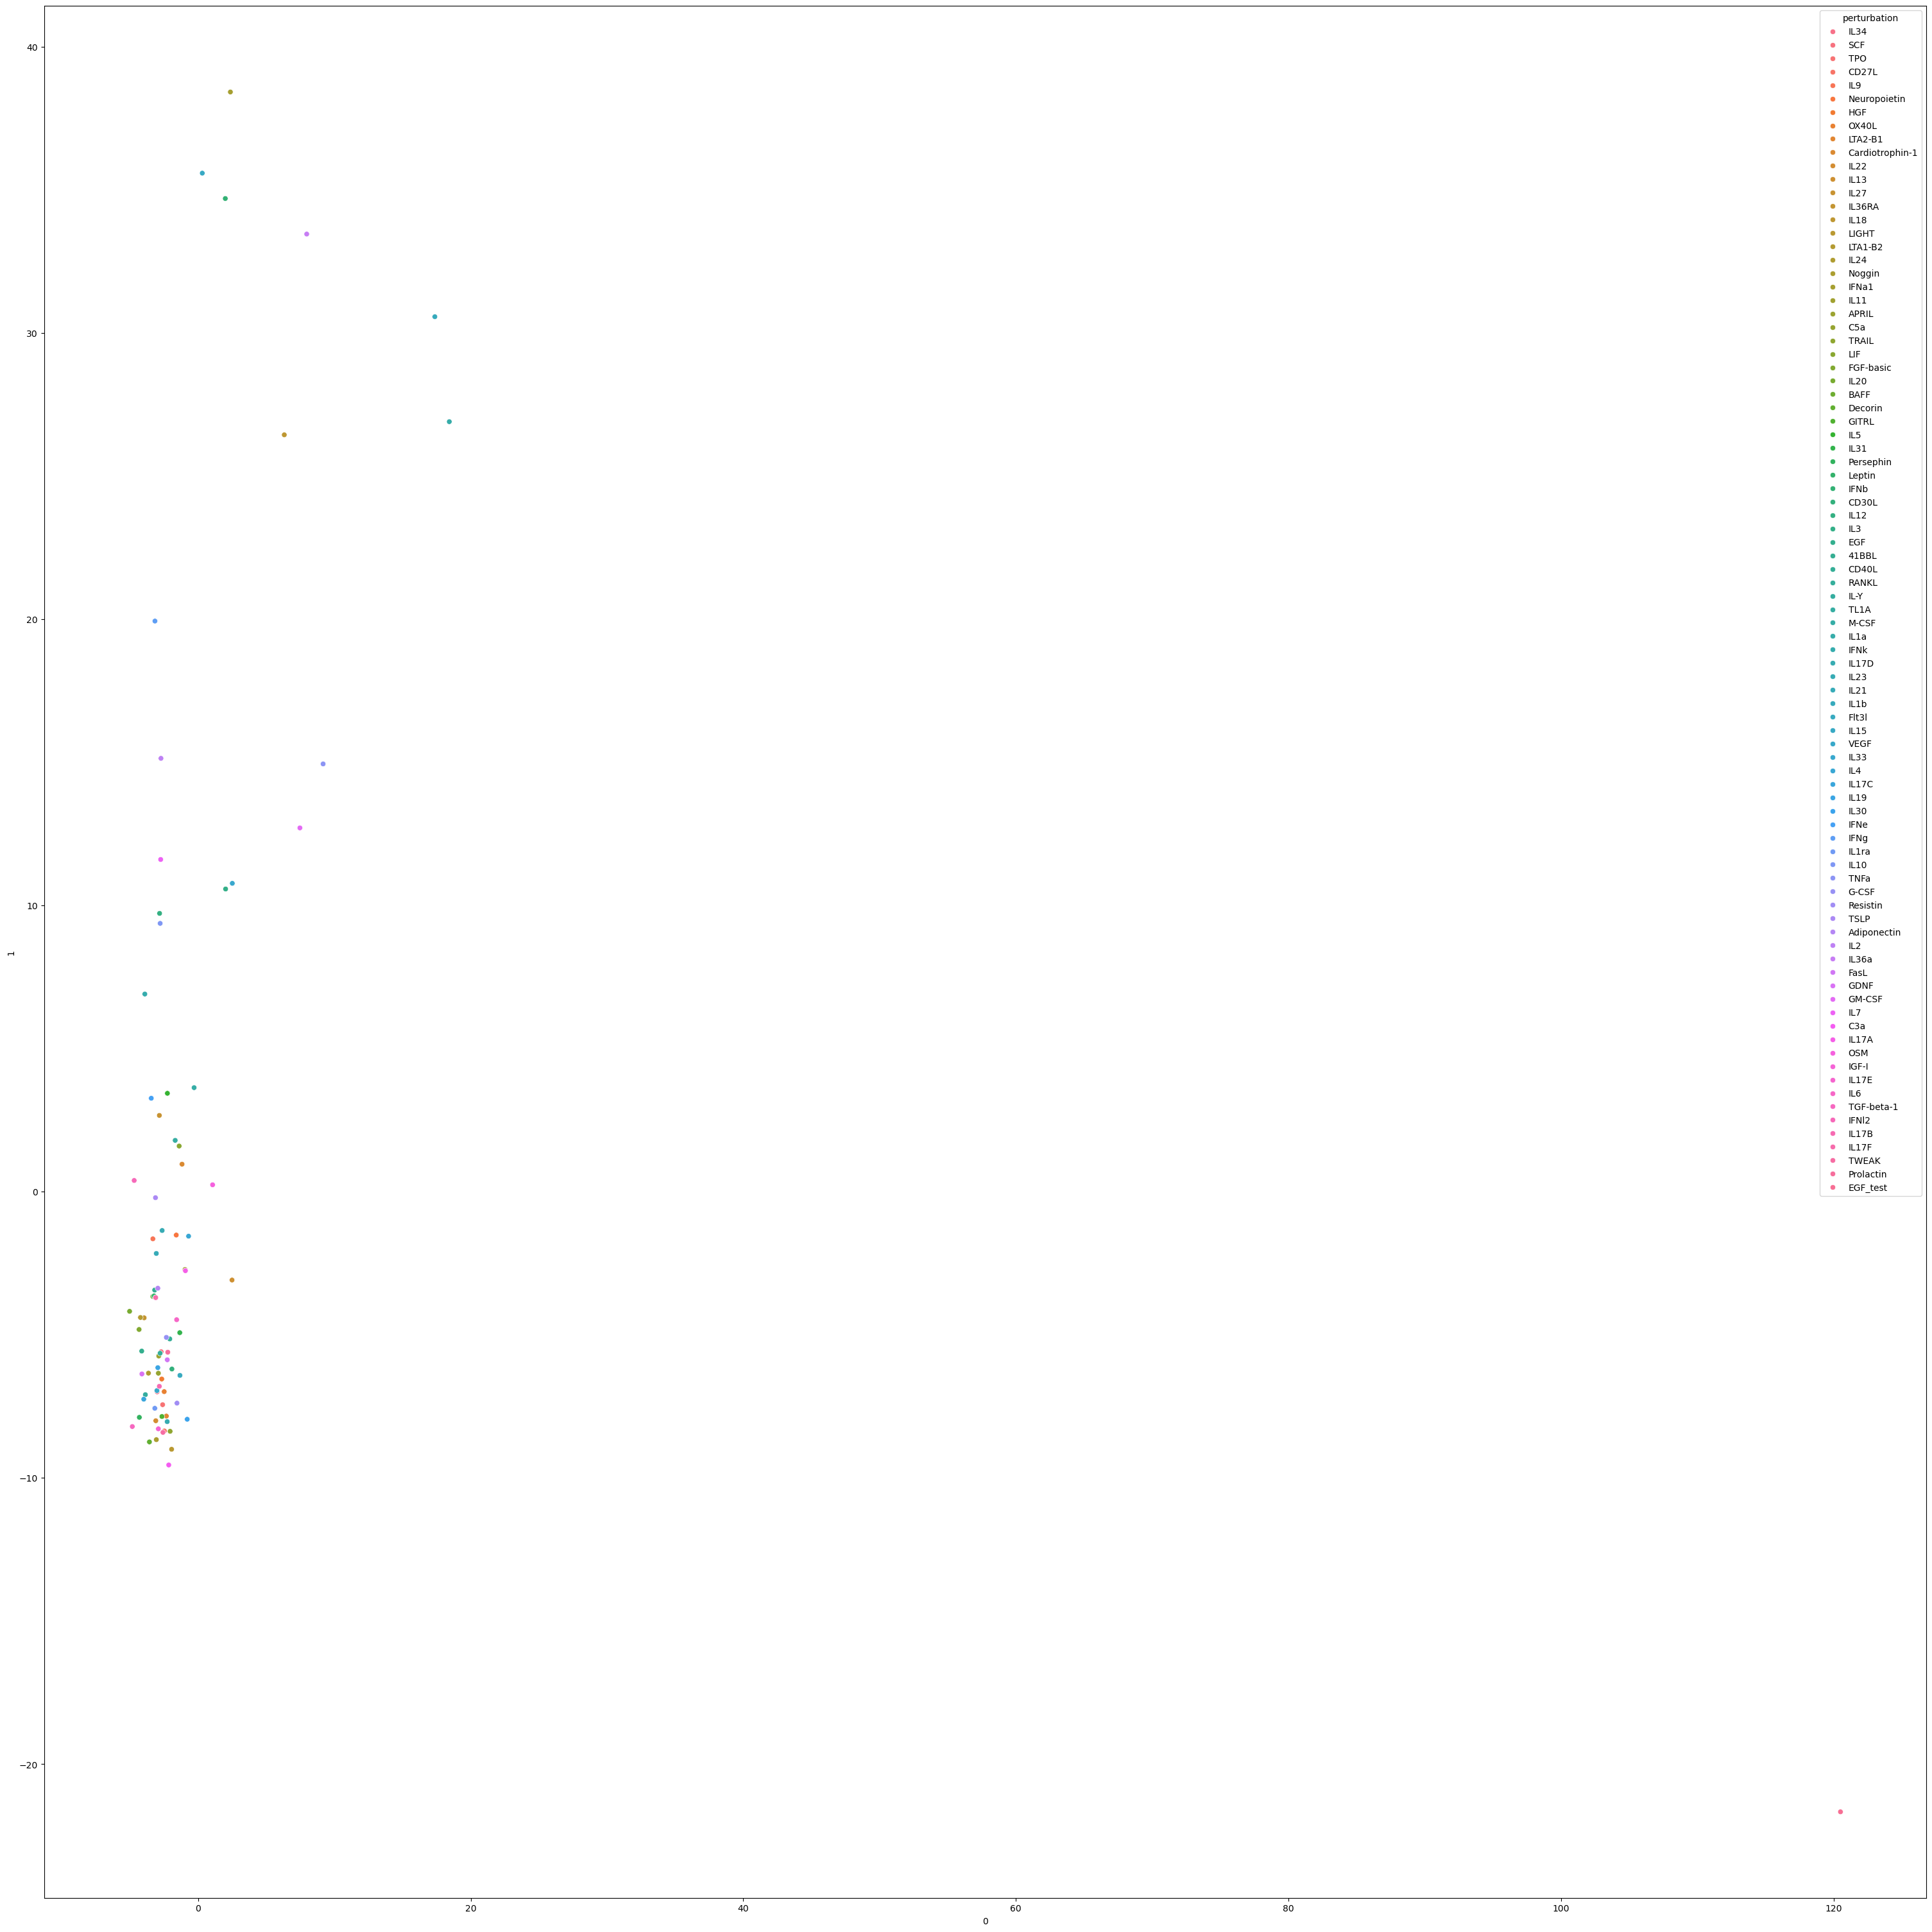

In [156]:
pert_vec_components_df = pd.DataFrame(pert_vec_components)
all_vec_list = list(pert_vec_dic.keys())
all_vec_list.append("EGF_test")
pert_vec_components_df["perturbation"] = all_vec_list
fig, ax = plt.subplots(1, 1, figsize=(30, 30), layout="constrained")
sns.scatterplot(
    pert_vec_components_df,
    x=0,
    y=1,
    hue="perturbation",
    ax=ax
)
#EGF vector generated by the model (EGF_test) is at the bottom right

In [160]:
'''from numpy.linalg import norm
true = merged_new[(merged_new.obs["condition"]=="EGF") & (merged_new.obs["celltype"]=="B_cell")].X
predicted = pred.X
similarities = []
for cell in range(true.shape[0]):
    cell_true = true[cell,:]
    cell_pred = predicted[cell,:]
    sim = np.dot(cell_true, cell_pred)/(norm(cell_true)*norm(cell_pred))
    similarities.append(sim)
    if cell%10 == 0:
        print(cell)
'''

ZeroDivisionError: division by zero

In [183]:
list(set(merged.obs["condition"]))[:5]

['IL34', 'SCF', 'TPO', 'CD27L', 'IL9']

In [185]:
#train, predict expressions, and predict perturbation
def predict(model, pert, cell):
    
    pred, delta = model.predict(
    ctrl_key = 'PBS',
    stim_key = pert,
    celltype_to_predict = cell
    )
    
    return pred.X


pert_list = list(set(merged.obs["condition"]))[:5]
cell_type = "B_cell"

data_train = merged[~((merged.obs["celltype"] == cell_type) &
                      merged.obs["condition"].isin(pert_list))]

data_train = data_train.copy()
scgen.SCGEN.setup_anndata(data_train, batch_key="condition", labels_key="celltype")
model = scgen.SCGEN(data_train)

model.train(
max_epochs=100,
batch_size=32,
early_stopping=True,
early_stopping_patience=25
)


from numpy.linalg import norm
sim_dic = {}

for i, pert in enumerate(pert_list):

    predicted_exp = predict(model, pert, cell_type)
    true_exp = merged[(merged.obs["celltype"] == cell_type) & (merged.obs["condition"] == "IL34")].X

    predicted_mean = predicted_exp.mean(axis=0)
    true_mean = true_exp.mean(axis=0)
    if i == 0:
        predicted_means = np.reshape(predicted_mean, (-1,1))
    else:
        predicted_means = np.concatenate([predicted_means, np.reshape(predicted_mean, (-1,1))], axis=1)
    
    sim = np.dot(true_mean, predicted_mean)/(norm(true_mean)*norm(predicted_mean))
    print(pert, sim)
    sim_dic[pert] = sim


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 26/100:  26%|██▌       | 26/100 [06:52<19:34, 15.87s/it, v_num=1, train_loss_step=972, train_loss_epoch=1.03e+3]    
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 3017.898. Signaling Trainer to stop.


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
IL34 0.35162909602724973


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/env

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
SCF 0.397511971719131


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/env

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


TPO 0.3685567451817653


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


CD27L 0.40151351586005224


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yalda_y/mambaforge/envs/state_transition/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


IL9 0.37206585415531207


In [186]:
all_means = np.concatenate([predicted_means, np.reshape(true_mean, (-1, 1))], axis=1)
all_means = np.transpose(all_means)

In [187]:
pca = PCA(2)
components = pca.fit_transform(all_means)

In [188]:
components.shape

(6, 2)

<Axes: xlabel='0', ylabel='1'>

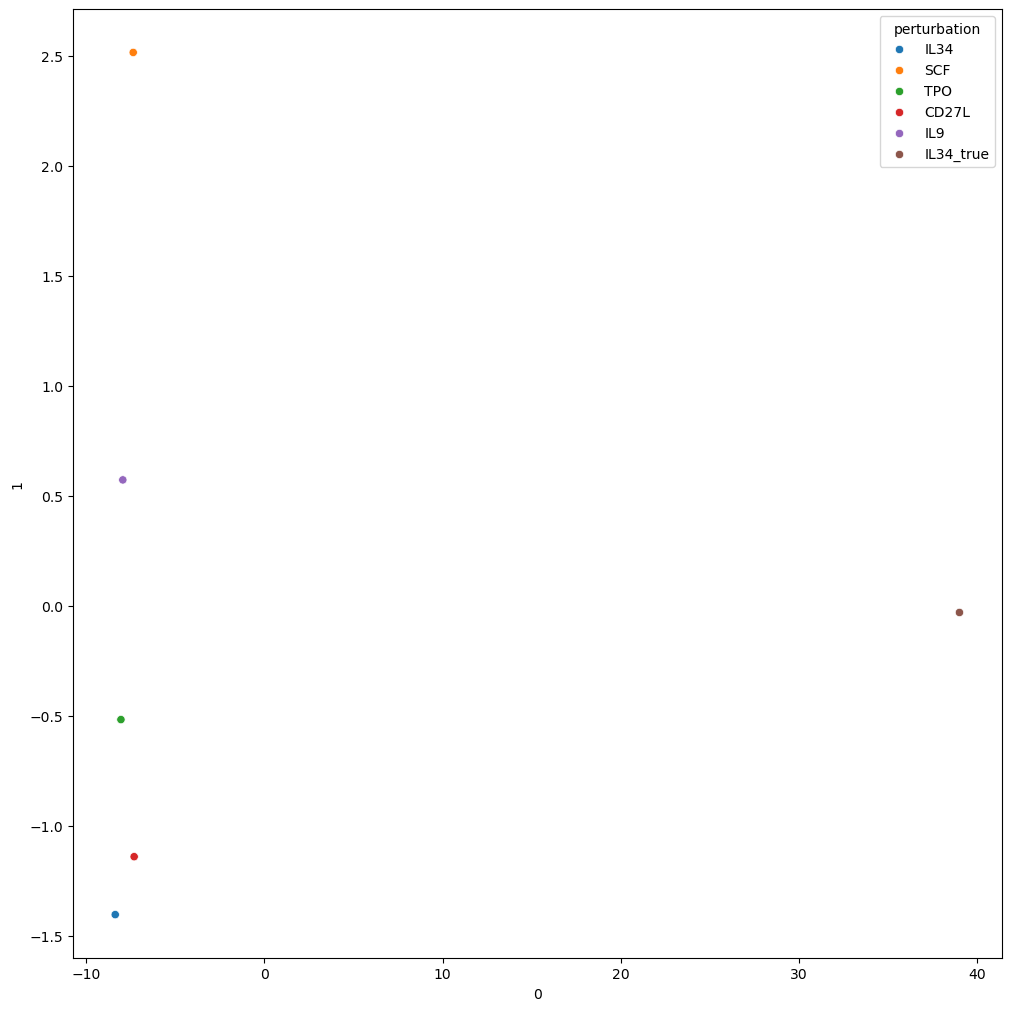

In [189]:
components_df = pd.DataFrame(components)
all_list = pert_list.copy()
all_list.append("IL34_true")
components_df["perturbation"] = all_list
fig, ax = plt.subplots(1, 1, figsize=(10, 10), layout="constrained")
sns.scatterplot(
    components_df,
    x=0,
    y=1,
    hue="perturbation",
    ax=ax
)